# Eligibility propagation with Spyx

References:
> A solution to the learning dilemma for recurrent networks of spiking neurons. G Bellec*, F Scherr*, A Subramoney, E Hajek, Darjan Salaj, R Legenstein, W Maass

> Additional explanations can be found in this report [here](https://github.com/florian6973/btt-spyx/blob/main/Report.pdf).

## Dependencies

In [ ]:
!pip install matplotlib scikit-learn spyx[loaders]

## Imports

In [4]:
import spyx
from spyx.nn import LeakyLinear, RecurrentLIFLight

# JAX imports
import os
import jax
from jax import numpy as jnp
import jmp # jax mixed-precision
import numpy as np

from jax_tqdm import scan_tqdm
from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# for surrogate loss training.
import optax

# rendering tools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
shd_dl = spyx.loaders.SHD_loader(256,128,128)

130864128it [00:14, 9181086.13it/s]                                


Extracting ./data\SHD\shd_train.h5.zip to ./data\SHD


38141952it [00:04, 8919111.29it/s]                               


Extracting ./data\SHD\shd_test.h5.zip to ./data\SHD


In [5]:
key = jax.random.PRNGKey(0)
x,y = shd_dl.train_epoch(key)

In [6]:
def lsnn_shd(x, state=None):
    n_rec = 400
    tau = 20
    dt = 1
    core = hk.DeepRNN([
        hk.Linear(n_rec),
        RecurrentLIFLight(n_rec,
            tau=tau,
            thr=0.8,
            dt=dt,
            dtype=jnp.float32,
            dampening_factor=0.3,
            tau_adaptation=500,
            beta=0.07 * jnp.ones(n_rec),
            tag='',
            stop_gradients=True,
            w_rec_init=None,
            n_refractory=3,
            rec=True,),
       LeakyLinear(n_rec, 20, jnp.exp(-dt/tau))
    ])
    spikes, hiddens = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=128)#16) # unroll our model.
    
    return spikes, hiddens

In [7]:
x.shape

(25, 256, 16, 128)

In [8]:
y.shape

(25, 256)

In [9]:
# Create a random key
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
SNN = hk.without_apply_rng(hk.transform(lsnn_shd))

x0 = jnp.zeros((1, 256, 128))
params = SNN.init(rng=key, x=x0)


In [21]:
def gd(SNN, params, dl, epochs=300, schedule=3e-4):

    # We use optax for our optimizer.
    opt = optax.adam(learning_rate=schedule)

    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()

    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params

    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets):
        readout = SNN.apply(weights, events)
        traces, V_f = readout
        return Loss(traces, targets)

    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval)

    rng = jax.random.PRNGKey(0)

    # compile the meat of our training loop for speed
    @jax.jit
    def train_step(state, data):
        # unpack the parameters and optimizer state
        grad_params, opt_state = state
        # unpack the data into x, y
        events, targets = data
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient
        loss, grads = surrogate_grad(grad_params, events, targets)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state]
        return new_state, loss

    # For validation epochs, do the same as before but compute the
    # accuracy, predictions and losses (no gradients needed)
    @jax.jit
    def eval_step(grad_params, data):
        # unpack our data
        events, targets = data
        # decompress information along temporal axis
        events = jnp.unpackbits(events, axis=1)
        # apply the network to the data
        readout = SNN.apply(grad_params, events)
        # unpack the final layer outputs and end state of each SNN layer
        traces, V_f = readout
        # compute accuracy, predictions, and loss
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        # we return the parameters here because of how jax.scan is structured.
        return grad_params, jnp.array([acc, loss])


    val_data = dl.val_epoch()

    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = dl.train_epoch(shuffle_rng)

        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# our function which computes and updates gradients for one batch
            [curr_params, curr_opt_state], # initialize with parameters and optimizer state of current epoch
            train_data,# pass the newly shuffled training data
            train_data.obs.shape[0]# this corresponds to the number of training batches
        )

        new_params, _ = end_state

        # val epoch
        _, val_metrics = jax.lax.scan(
            eval_step,# func
            new_params,# init
            val_data,# xs
            val_data.obs.shape[0]# len
        )
        
        print(val_metrics)


        return end_state, jnp.concatenate([jnp.expand_dims(jnp.mean(train_loss),0), jnp.mean(val_metrics, axis=0)])
    # end epoch

    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state], # metric arrays
        jnp.arange(epochs), #
        epochs # len of loop
    )

    final_params, final_optimizer_state = final_state


    # return our final, optimized network.
    return final_params, metrics

In [22]:
grad_params, metrics = gd(SNN, params, shd_dl, epochs=60) # this takes a minute or two to compile on Colab because of weak CPU compute.


x_input (256, 128, 128)
iin (256, 400)
x_input (256, 128, 128)
iin (256, 400)
Traced<ShapedArray(float32[6,2])>with<DynamicJaxprTrace(level=1/0)>


  0%|          | 0/60 [00:00<?, ?it/s]

In [23]:
print(metrics[:, 2])
print(metrics[:, 1])

[3.3396416 2.7394361 2.5159357 2.3944805 2.311097  2.259231  2.254243
 2.1969118 2.1640594 2.1198297 2.1289842 2.0941677 2.0898578 2.0560226
 2.0525196 2.020626  2.0091455 1.9951267 1.9801593 1.9889545 1.9905777
 1.9748755 1.9900997 1.9820318 1.9319314 1.9379961 1.9430561 1.9162053
 1.9080309 1.9121706 1.9099082 1.8986979 1.9173098 1.8822697 1.8949358
 1.8759296 1.8963922 1.872345  1.8697561 1.8655033 1.8835618 1.8791912
 1.8660862 1.8646512 1.853204  1.8516091 1.8390594 1.842894  1.8579562
 1.8335865 1.8404154 1.8479518 1.8314093 1.818244  1.8273256 1.8267124
 1.8125165 1.8106669 1.8294351 1.8155215]
[0.13346355 0.30013022 0.40429688 0.4811198  0.5286459  0.57682294
 0.5839844  0.6197917  0.6295573  0.6790365  0.66015625 0.69921875
 0.69596356 0.718099   0.7285156  0.74609375 0.76171875 0.765625
 0.7714844  0.7623698  0.75846356 0.780599   0.76627606 0.764974
 0.79752606 0.8046875  0.7727865  0.8072917  0.8092448  0.8170573
 0.8222656  0.8255209  0.8105469  0.8300781  0.82682294 0.822

Performance: train_loss=1.655739426612854, val_acc=0.859375, val_loss=1.815521478652954


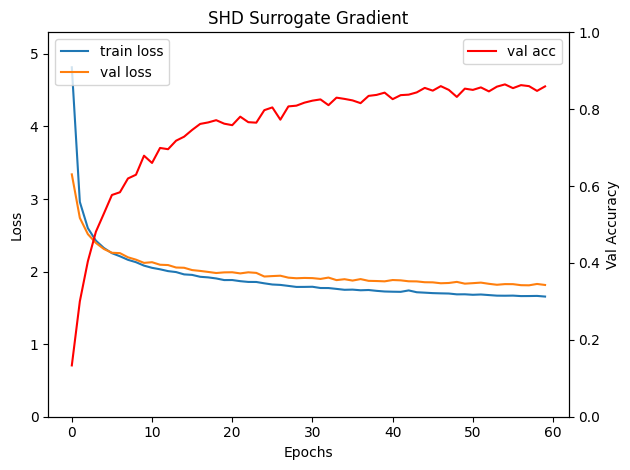

In [24]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*metrics[-1]))


fig, ax1 = plt.subplots()
ax1.plot(metrics[:,0], label="train loss")
ax1.plot(metrics[:,2], label="val loss")
ax1.legend(loc='upper left')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_ylim(0, max(np.max(metrics[:,0]), np.max(metrics[:,2]))*1.1)
ax2 = ax1.twinx()
ax2.plot(metrics[:,1], label="val acc", color='r')
ax2.set_ylabel("Val Accuracy")
ax2.set_ylim(0,1)
ax2.legend()

plt.title("SHD Surrogate Gradient")
plt.tight_layout()
plt.show()

In [25]:
def test_gd(SNN, params, dl):

    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()

    @jax.jit
    def test_step(params, data):
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(params, events)
        traces, V_f = readout
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        return params, [acc, loss, pred, targets]

    test_data = dl.test_epoch()

    _, test_metrics = jax.lax.scan(
            test_step,# func
            params,# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )

    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    return acc, loss, preds, tgts


In [26]:
acc, loss, preds, tgts = test_gd(SNN, grad_params, shd_dl)
print("Accuracy:", acc, "Loss:", loss)


x_input (256, 128, 128)
iin (256, 400)
Accuracy: 0.7529297 Loss: 2.0053806


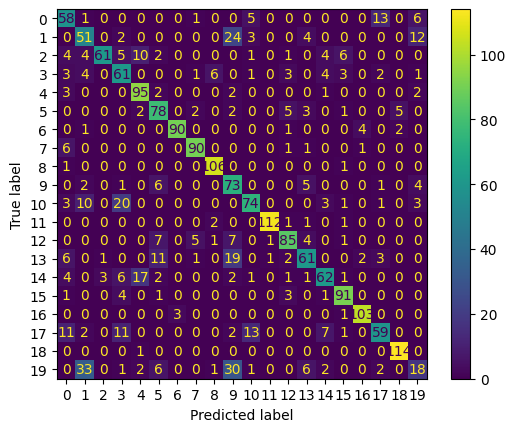

In [27]:
cm = confusion_matrix(tgts, preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [ ]:
LOSS REGULARIZATION PAPER + SOFTMAX